In [ ]:
# Яка середня кількість поїздок на годину у пікові години протягом тижня, і як вона змінюється між днями тижня

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, count, avg, to_timestamp, date_trunc
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder \
    .appName("MaxDailyTripsPerDriver") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()


In [18]:

df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")


In [ ]:
df = df_trip.join(
    df_fare,
    on=["medallion", "hack_license", "pickup_datetime"],
    how="inner"
)

df = df.withColumn("pickup_time", to_timestamp("pickup_datetime")) \
       .withColumn("hour", hour("pickup_time")) \
       .withColumn("day_of_week", dayofweek("pickup_time"))  # 1 = Sunday, 7 = Saturday

df_peak = df.filter(
    ((col("hour") >= 7) & (col("hour") <= 10)) | ((col("hour") >= 16) & (col("hour") <= 20))
)

df_grouped = df_peak.groupBy("day_of_week", "hour").agg(
    count("*").alias("trip_count")
)

window_spec = Window.partitionBy("day_of_week", "hour")

df_result = df_grouped.withColumn(
    "avg_trips_per_hour", avg("trip_count").over(window_spec)
).select("day_of_week", "hour", "avg_trips_per_hour").distinct().orderBy("day_of_week", "hour")


In [23]:
df_result.write.option("header", True).mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/5.csv")

25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 11:30:15 WARN RowBasedKeyValueBatch: Calling spill() on

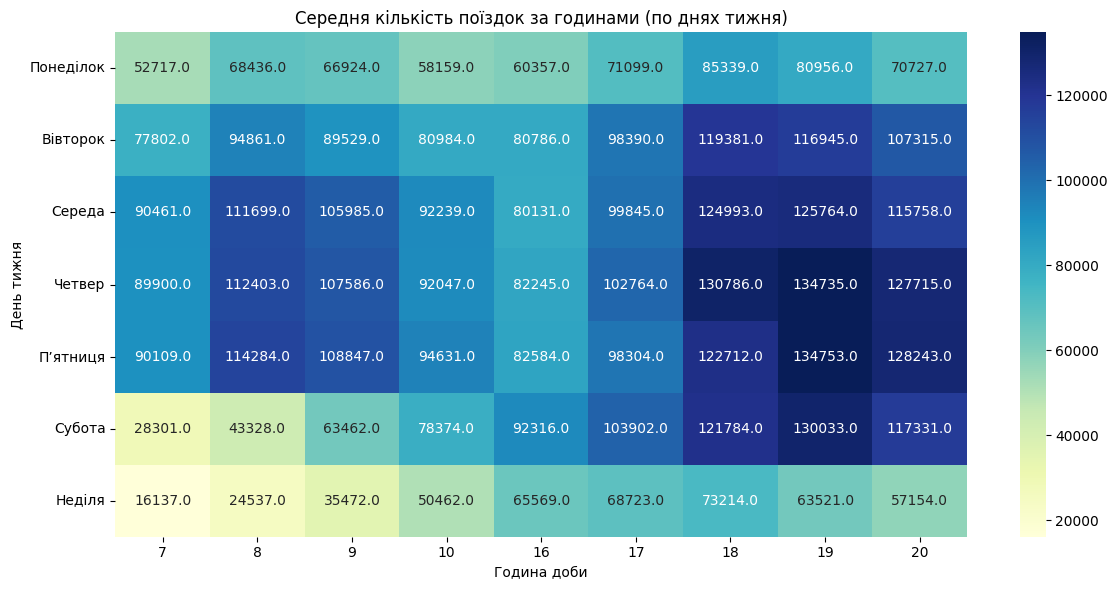

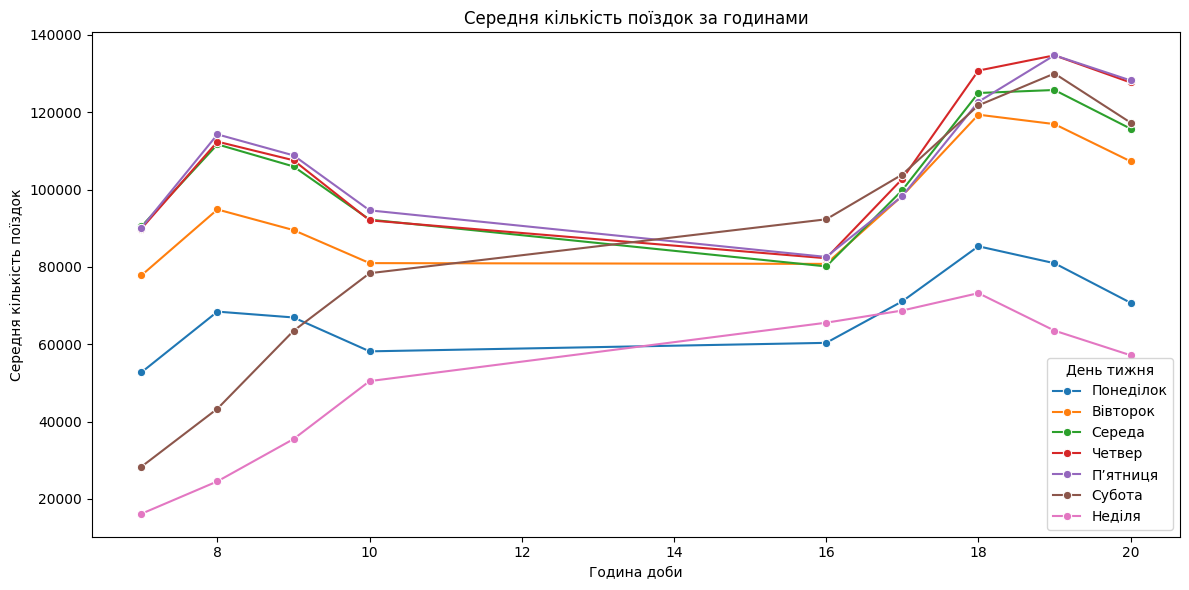

In [ ]:
pdf_result = df_result.toPandas()
weekday_map = {
    1: "Неділя", 2: "Понеділок", 3: "Вівторок", 4: "Середа",
    5: "Четвер", 6: "П’ятниця", 7: "Субота"
}
pdf_result["weekday_name"] = pdf_result["day_of_week"].map(weekday_map)

weekday_order = ["Понеділок", "Вівторок", "Середа", "Четвер", "П’ятниця", "Субота", "Неділя"]
pdf_result["weekday_name"] = pd.Categorical(pdf_result["weekday_name"], categories=weekday_order, ordered=True)

heatmap_data = pdf_result.pivot(index="weekday_name", columns="hour", values="avg_trips_per_hour")
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Середня кількість поїздок за годинами (по днях тижня)")
plt.xlabel("Година доби")
plt.ylabel("День тижня")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_result, x="hour", y="avg_trips_per_hour", hue="weekday_name", marker="o")
plt.title("Середня кількість поїздок за годинами")
plt.xlabel("Година доби")
plt.ylabel("Середня кількість поїздок")
plt.legend(title="День тижня")
plt.tight_layout()
plt.show()